# TP3 LSTM de Rios Valdez Matias

In [ ]:
# https://colab.research.google.com/drive/1E9nqw_Va76unCRsOmOchlqlOC4-4C6jP?usp=sharing

# Problema de negocio

El *Servicio Nacional del Manejo del Fuego* dependiente del **Ministerio de Ambiente de la Nación Argentina** utiliza el sistema de evaluación de peligro y alerta temprana de incendios forestales para emitir alertas tempranas de incendios. Se propone la utilización de algoritmos deep learning (LSTM) para la predicción temprana de temperatura media como input de una matriz de riesgo que permita emitir alertas de fuego más precisas. Como piloto se utilizará el registro historico de temperaturas diarias del Parque Nacional Nahuel Huapi. 

# Enlace a Drive con serie de tiempo
[Enlace a Drive](https://drive.google.com/file/d/10uJeqT00Z7xNkLQxLkgHUuxS1uoiSXAP/view?usp=drive_link)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Conección con Drive
!pip install --upgrade --no-cache-dir gdown

!gdown --id 10uJeqT00Z7xNkLQxLkgHUuxS1uoiSXAP


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=10uJeqT00Z7xNkLQxLkgHUuxS1uoiSXAP 



In [ ]:
# Importo librerías
import pandas as pd
import numpy as np
from tensorflow import keras


# Lectura y tratamiento de archivo

In [ ]:
col_names=['ubic', 'lat', 'lon', 'date','tmp'] # tmp = temperatura media
df = pd.read_csv("/content/drive/MyDrive/UBA Maestria/Bases de Datos/Lat-41.75_Lon-71.75.csv", sep=";", names = col_names, header = None)
df.head()

,ubic,lat,lon,date,tmp
0,248,-41.75,-71.75,1/1/1961,9.7
1,248,-41.75,-71.75,2/1/1961,10.9
2,248,-41.75,-71.75,3/1/1961,11.0
3,248,-41.75,-71.75,4/1/1961,12.3
4,248,-41.75,-71.75,5/1/1961,14.7


In [ ]:
# Coloco date como index
df = df.set_index("date")
df.head()

,ubic,lat,lon,tmp
date,,,,
1/1/1961,248,-41.75,-71.75,9.7
2/1/1961,248,-41.75,-71.75,10.9
3/1/1961,248,-41.75,-71.75,11.0
4/1/1961,248,-41.75,-71.75,12.3
5/1/1961,248,-41.75,-71.75,14.7


In [ ]:
df.shape

(18250, 4)

In [ ]:
# Quito valores nulos
df.fillna(0, inplace=True)

In [ ]:
df.shape

(18250, 4)

In [ ]:
# Normalizo tmp
df["tmp"] = (df["tmp"] - df["tmp"].min()) / (df["tmp"].max() - df["tmp"].min())
df.head()

,ubic,lat,lon,tmp
date,,,,
1/1/1961,248,-41.75,-71.75,0.533546
2/1/1961,248,-41.75,-71.75,0.571885
3/1/1961,248,-41.75,-71.75,0.575080
4/1/1961,248,-41.75,-71.75,0.616613
5/1/1961,248,-41.75,-71.75,0.693291


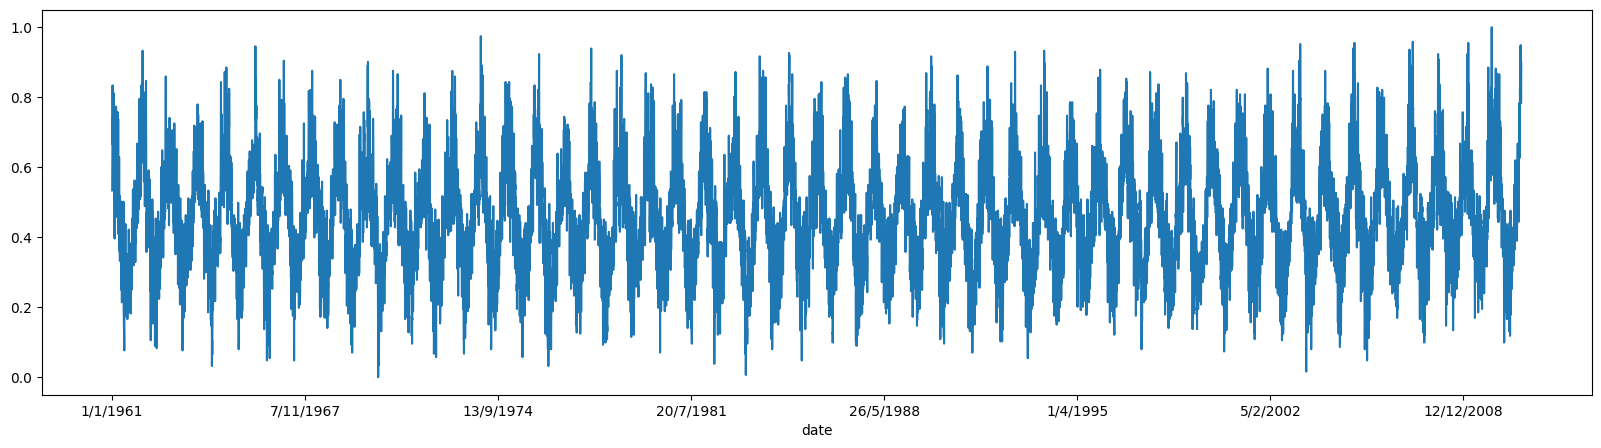

In [ ]:
# Plot de tmp
df["tmp"].plot.line(figsize=(20,5));

In [ ]:
df.drop(columns=["ubic", "lat", "lon"], inplace=True)
df.head()

,tmp
date,
1/1/1961,0.533546
2/1/1961,0.571885
3/1/1961,0.575080
4/1/1961,0.616613
5/1/1961,0.693291


# Entrenamiento e implementacion del modelo LSTM

In [ ]:
# Divido en entrenamiento y testeo
df_train = df[df.index < '2000/01/01']
df_test = df[df.index >= '2000/01/01']
df_train.shape, df_test.shape

((7800, 1), (10450, 1))

In [ ]:
window_size = 7 # hiperparámetro
cols = df.columns

X_train = pd.concat([pd.concat([df_train[c].shift(w, fill_value=0) for w in range(1, window_size+1)], axis=1, keys=[f"{c}_{w}" for w in range(1, window_size+1)]) for c in cols], axis=1)
X_test  = pd.concat([pd.concat([df_test[c].shift(w, fill_value=0) for w in range(1, window_size+1)], axis=1, keys=[f"{c}_{w}" for w in range(1, window_size+1)]) for c in cols], axis=1)
y_train = df_train["tmp"] # temp media
y_test = df_test["tmp"] # temp media

In [ ]:
X_train.head(), y_train.head()

(              tmp_1     tmp_2     tmp_3     tmp_4  tmp_5  tmp_6  tmp_7
 date                                                                  
 1/1/1961   0.000000  0.000000  0.000000  0.000000    0.0    0.0    0.0
 2/1/1961   0.533546  0.000000  0.000000  0.000000    0.0    0.0    0.0
 10/1/1961  0.571885  0.533546  0.000000  0.000000    0.0    0.0    0.0
 11/1/1961  0.699681  0.571885  0.533546  0.000000    0.0    0.0    0.0
 12/1/1961  0.741214  0.699681  0.571885  0.533546    0.0    0.0    0.0,
 date
 1/1/1961     0.533546
 2/1/1961     0.571885
 10/1/1961    0.699681
 11/1/1961    0.741214
 12/1/1961    0.728435
 Name: tmp, dtype: float64)

In [ ]:
# Transformo a tensor
X_train = X_train.values.reshape( (X_train.shape[0], 1, X_train.shape[1]) )
X_test = X_test.values.reshape( (X_test.shape[0], 1, X_test.shape[1]) )

In [ ]:
X_train.shape

(7800, 1, 7)

In [ ]:
# Modelo de keras

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[X_train.shape[1], X_train.shape[2]]),
    
    keras.layers.LSTM(units=365, return_sequences=True), # hiperparametro: 365 días pq el ciclo de temperaturas es de 1 año de 365 días
    #keras.layers.LSTM(units=3650, return_sequences=True), 
    # Si se usa más de una capa de LSTM, todas las capas tienen que tener return_sequences=True menos la última
    keras.layers.LSTM(units=7200), # x dias igual a y años

    keras.layers.Dense(30, activation='relu'), 
    keras.layers.Dense(10, activation="relu"),
    #keras.layers.Dense(5, activation="relu"),

    # capa de salida --> regresión es 1
    keras.layers.Dense(1, activation="linear")
])

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=50, verbose=True)

Epoch 1/8
156/156 [==============================] - 32s 178ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 2/8
156/156 [==============================] - 25s 162ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 3/8
156/156 [==============================] - 27s 174ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 4/8
156/156 [==============================] - 25s 162ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 5/8
156/156 [==============================] - 25s 163ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 6/8
156/156 [==============================] - 25s 162ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 7/8
156/15

# Resultados





In [ ]:
# Predicciones
y_pred = model.predict(X_test)

# RMSE
np.sqrt(np.mean((y_pred.flatten() - y_test)**2))

327/327 [==============================] - 13s 37ms/step


0.07024042869568246

In [ ]:
# Flatten y plot
df_test["pred"] = y_pred.flatten()

<ipython-input-34-380d6ccb4f9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred"] = y_pred.flatten()


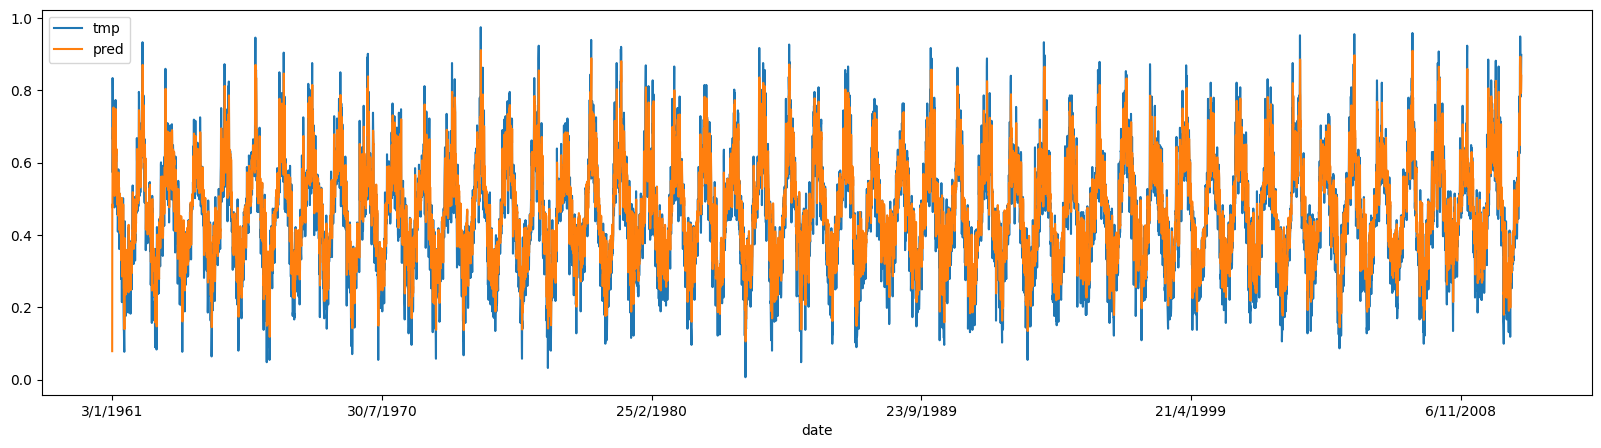

In [ ]:
# Plot
df_test.plot.line(figsize=(20, 5));

# Conclusión
Dado un conjunto de datos de entrenamiento con *7800 registros historicos de temperatura media del Parque Nacional Nahuel Huapi*, se implemento un modeo del tipo Long short-term memory (LSTM), obteniendo como resultado las predicciones para toda la serie de tiempo con un **Error Cuadratico Medio (RMSE)** igual a 0.0.07024042869568246 o **7%**. 
El modelo fue testeado con una, dos, y tres capas densas y de ocho a 10 epocas, obteniendo el menor RMSE, con dos capas densas, y ocho epocas. 